In [1]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

trials = 10000
path = '/home/ambra/Desktop/cluster-morgana/run0406_%dx_ebl/run0406/run0406_ID000126/csv/' %trials

Nchunk = 30

texp = [1,5,10,100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]

csvName = [[]*i for i in range(len(texp))]
for i in range(len(chunk)) :  
    for j in range(len(texp)) :
        csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
        
# merge files ---!
csvMerged= []
for j in range(len(texp)) :
    csvMerged.append('run0406_%dx_%ds.csv' % (trials,texp[j]))

    fout = open(path+csvMerged[j],'w+')
    # first file ---!
    for line in open(path+csvName[j][0]):
        fout.write(line)
    # remaining files ---!    
    for i in range(len(chunk)-1):
        f = open(path+csvName[j][i+1])
        next(f) # skip the header ---!
        for line in f:
             fout.write(line)
        f.close() 
    fout.close()
    
print(csvMerged)

# data params ---!
threshold = 0.5
xlim=0.2
texp=[1,5,10,100]
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
# conf intervals params ---!
nstd = [1,2,3,5]
conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
# img params ---!
fontsize=12
CI_colors = ['k', 'r', 'g', 'w']

['run0406_10000x_1s.csv', 'run0406_10000x_5s.csv', 'run0406_10000x_10s.csv', 'run0406_10000x_100s.csv']


verify trials =  17000
verify trials =  10000


================ texp = 1s ==============


ZERO DETECTION RATE : 19.92
DETECTION RATE : 80.08
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 71.43
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 71.38


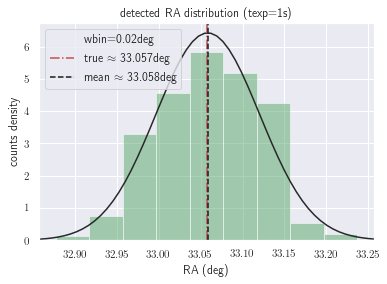

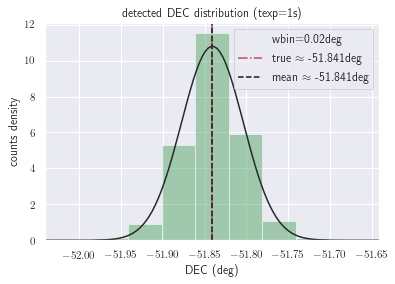

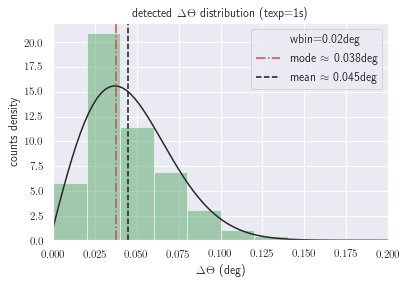

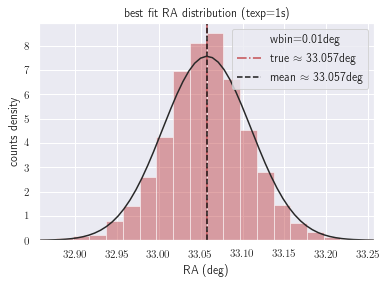

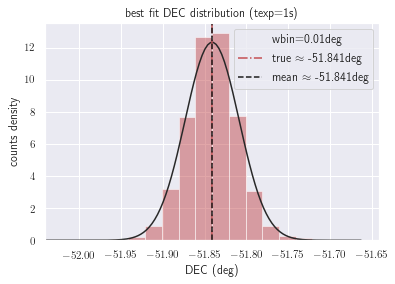

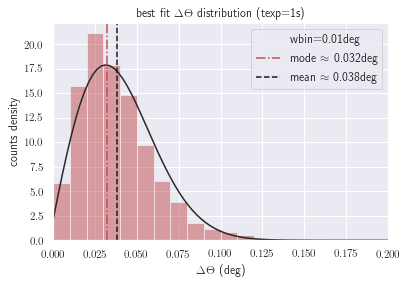

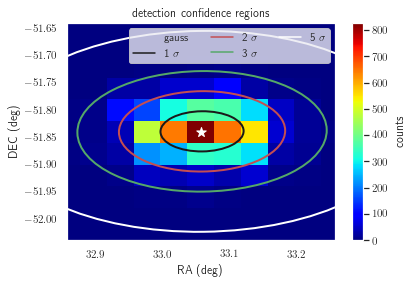

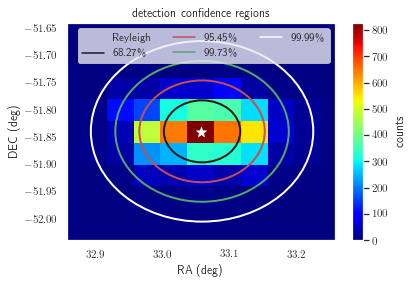

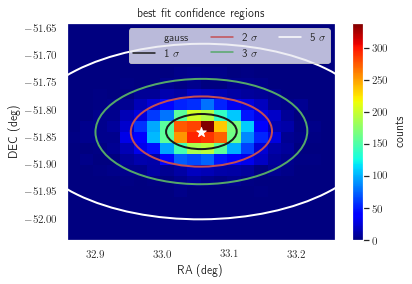

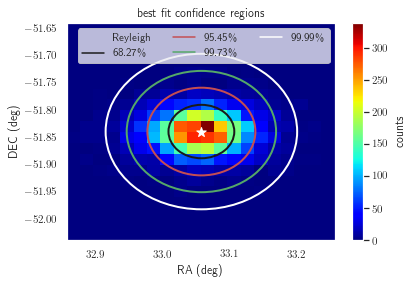



================ texp = 5s ==============


ZERO DETECTION RATE : 0.030000000000001137
DETECTION RATE : 99.97
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.97
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.97


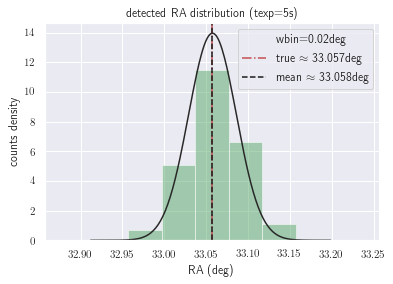

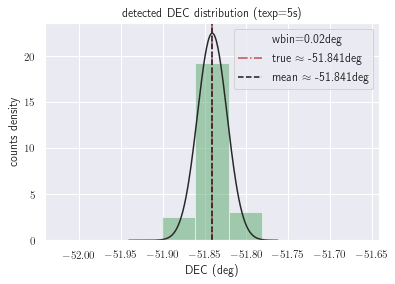

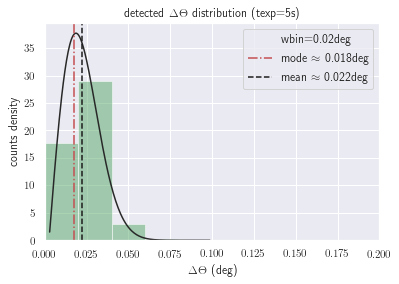

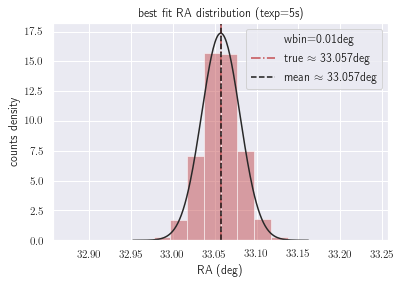

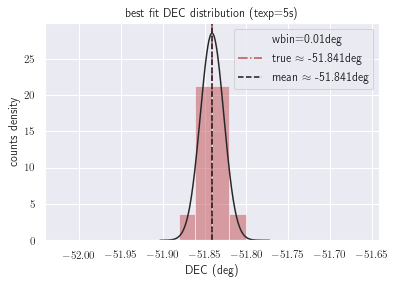

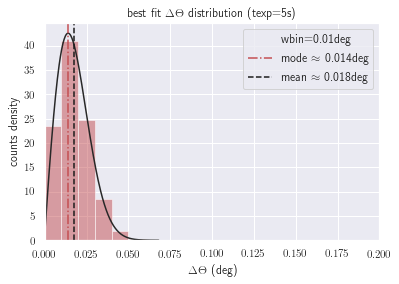

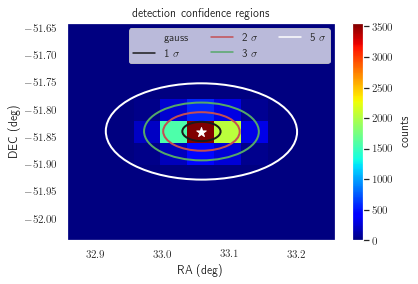

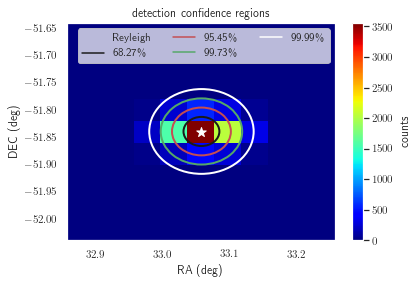

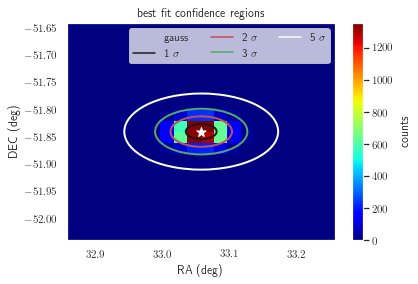

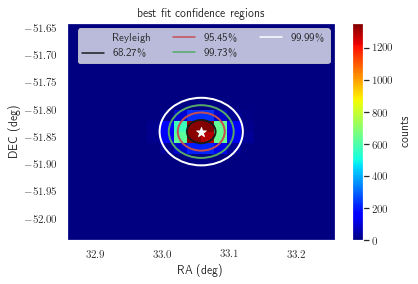



================ texp = 10s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0


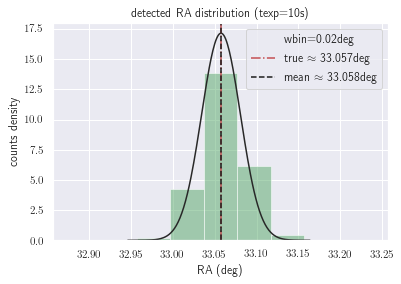

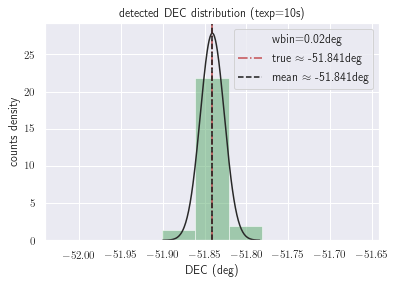

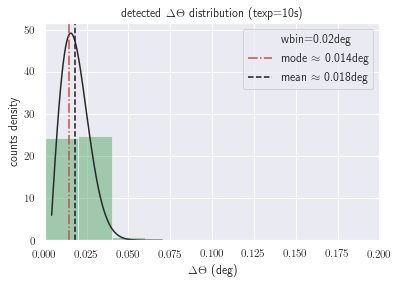

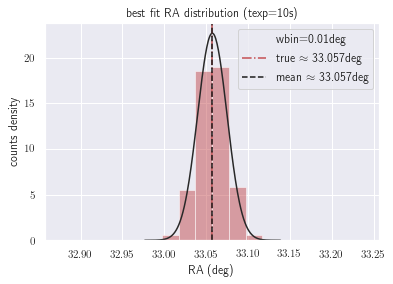

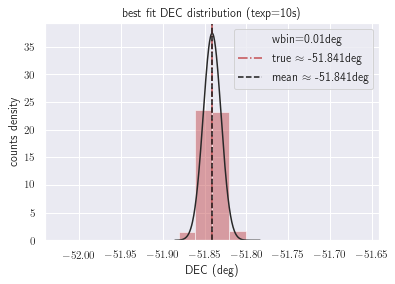

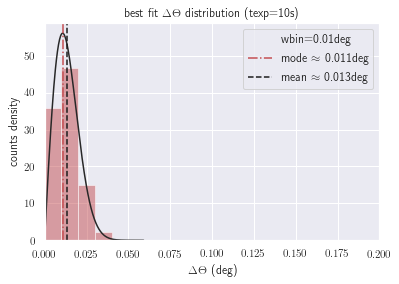

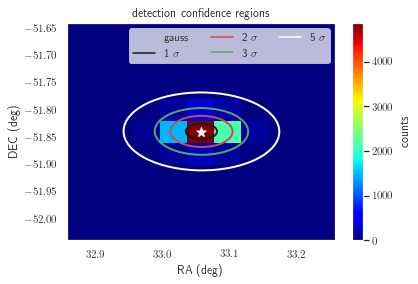

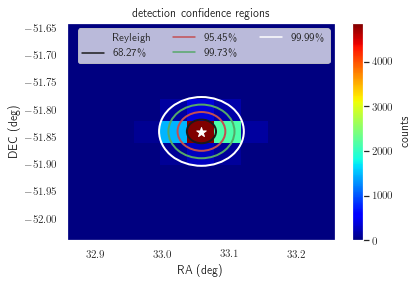

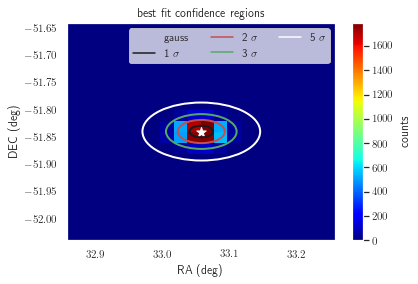

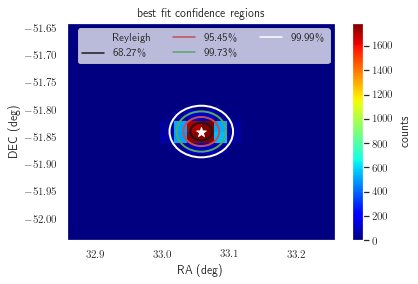



================ texp = 100s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0


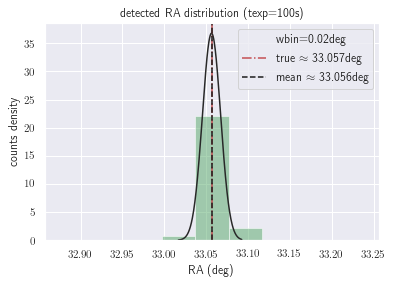

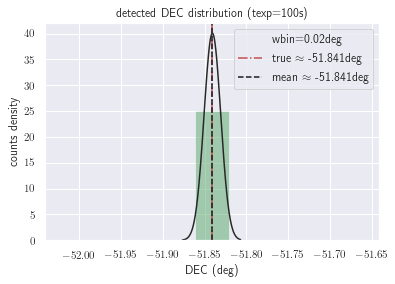

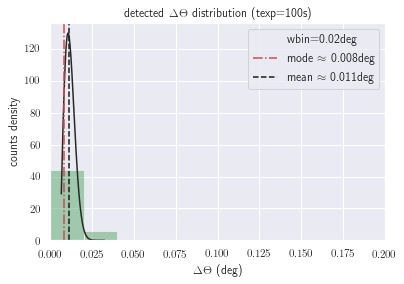

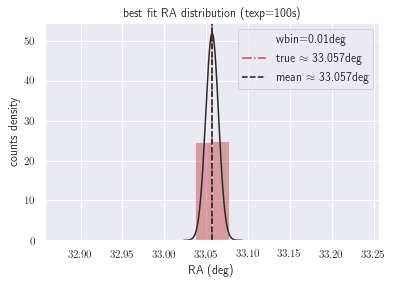

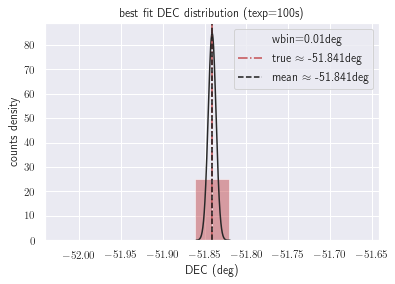

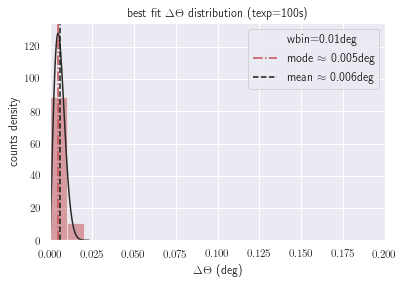

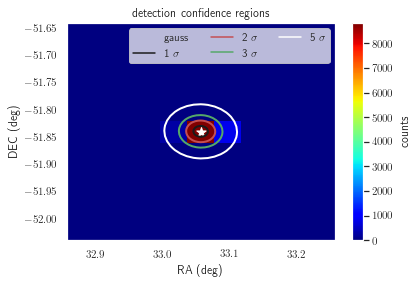

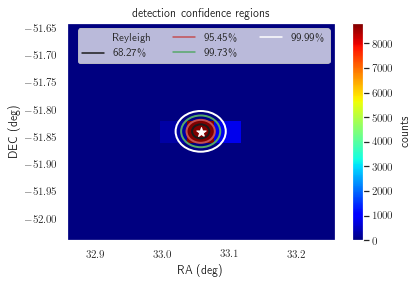

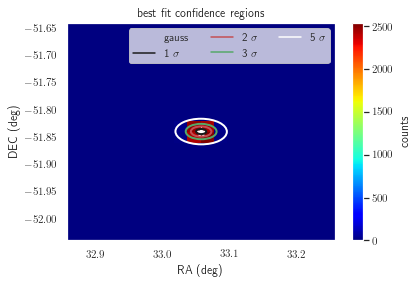

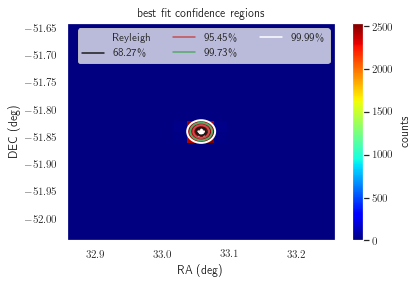



ok


In [4]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from module_statistics import *


# hist params ---!
#width = 0.02
#nbin = int(threshold / width)
Dwidth = 0.02
Dnbin = int(threshold / Dwidth)
Fwidth = 0.01
Fnbin = int(threshold / Fwidth)


for n in range(len(texp)) :  
        
    # store values ---!
    filename = csvMerged[n]
    
    # load DataFrame and column names ---!
    df = pd.read_csv(path+filename)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop duplicates ---! 
    df.sort_values(cols[0], inplace = True) 
    # dropping ALL duplicte values 
    df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop NaN ---!
    df = df.dropna()
        
    print('\n\n================ texp = %ds ==============\n\n' %texp[n])
    
    # set arrays ---!
    trial = np.array(df[cols[0]])
    raDet = np.array(df[cols[5]])
    decDet = np.array(df[cols[6]])
    raFit = np.array(df[cols[7]])
    decFit = np.array(df[cols[8]])
    
    perc = 100 * (len(trial)/trials)
    print('ZERO DETECTION RATE :', 100-perc)
    print('DETECTION RATE :', perc)
    
    # DETECTION ---!
    distance_det = []
    d_det = []
    ra_det = []
    dec_det = []

    for i in range(len(raDet)) :
        if -90 <= decDet[i] <= 90 and 0 <= raDet[i] <= 360 :
            det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(det_coord).deg)
            distance_det.append(dist)                  
    
            if dist < threshold :
                d_det.append(dist)
                ra_det.append(raDet[i]) 
                dec_det.append(decDet[i]) 
            
    perc_det = len(d_det)/trials * 100
    perc_det2 = len(d_det)/len(distance_det) * 100
    print('DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det)
    
    # MEAN DET ---!
    mean_raDet = np.nanmean(ra_det)
    mean_decDet = np.nanmean(dec_det)
    mean_det = np.nanmean(d_det)
    std_det = np.nanstd(d_det)
    
    tmp = 0
    for i in range(len(d_det)) :
        tmp += d_det[i]**2
        
    mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
    MLE_det = 0.606/mode_det
    
    # FIT MAX LIKELIHOOD ---!
    distance_fit = []
    d_fit = []
    ra_fit = []
    dec_fit = []

    for i in range(len(raFit)) :
        if -90 <= decFit[i] <= 90 and 0 <= raFit[i] <= 360 :
            fit_coord = SkyCoord(ra = raFit[i]*u.deg, dec = decFit[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(fit_coord).deg)
            distance_fit.append(dist)                  
    
            if dist < threshold :
                d_fit.append(dist)
                ra_fit.append(raFit[i]) 
                dec_fit.append(decFit[i]) 
        
    perc_fit = len(d_fit)/trials * 100
    print('FIT RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_fit)  

    # MEAN FIT ---!
    mean_raFit = np.nanmean(ra_fit)
    mean_decFit = np.nanmean(dec_fit)
    mean_fit = np.nanmean(d_fit)
    std_fit = np.nanstd(d_fit)
        
    tmp = 0
    for i in range(len(d_fit)) :
        tmp += d_fit[i]**2
        
    mode_fit = np.sqrt(1/(2*len(d_fit)) * tmp)
    
   
    # DETECTION 1D ---!
    fig, ax = hist1d_gauss(ra_det, mean_raDet, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                           fontsize=fontsize, color='g', 
                           title='detected RA distribution (texp=%ds)' %texp[n],
                           xlabel='RA (deg)', ylabel='counts density',
                           filename='run0406_%ds_detRA.png' %texp[n])   
    plt.show()
    plt.close()
    
    fig, ax = hist1d_gauss(dec_det, mean_decDet, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                           threshold=threshold, fontsize=fontsize, color='g', alpha=0.5,
                           title='detected DEC distribution (texp=%ds)' %texp[n],
                           xlabel='DEC (deg)', ylabel='counts density',
                           filename='run0406_%ds_detDEC.png' %texp[n]) 
    plt.show()
    plt.close()
        
    fig, ax = hist1d_rayleigh(d_det, mean_det, rayleigh_prms={'loc':0, 'scale':mode_det}, 
                              nbin=Dnbin, width=Dwidth, fontsize=fontsize, color='g', threshold=threshold,
                              title='detected $\\Delta \\Theta$ distribution (texp=%ds)' %texp[n],
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename='run0406_%ds_DET.png' %texp[n])
    plt.show()
    plt.close()
        
    # BEST FIT 1D ---!
    fig, ax = hist1d_gauss(ra_fit, mean_raFit, loc=trueRA, threshold=threshold, nbin=Fnbin, width=Fwidth, 
                           fontsize=fontsize, color='r', 
                           title='best fit RA distribution (texp=%ds)' %texp[n],
                           xlabel='RA (deg)', ylabel='counts density',
                           filename='run0406_%ds_fitRA.png' %texp[n]) 
    plt.show()
    plt.close()
        
    fig, ax = hist1d_gauss(dec_fit, mean_decFit, loc=trueDEC, nbin=Fnbin, width=Fwidth,
                           threshold=threshold, fontsize=fontsize, color='r', alpha=0.5,
                           title='best fit DEC distribution (texp=%ds)' %texp[n], ax_thresh=xlim, 
                           xlabel='DEC (deg)', ylabel='counts density', 
                           filename='run0406_%ds_fitDEC.png' %texp[n]) 
    plt.show()
    plt.close()
        
    fig, ax = hist1d_rayleigh(d_fit, mean_fit, threshold=threshold, nbin=Fnbin, width=Fwidth,
                              fontsize=fontsize, color='r', rayleigh_prms={'loc':0, 'scale':mode_fit},
                              title='best fit $\\Delta \\Theta$ distribution (texp=%ds)' %texp[n], 
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename='run0406_%ds_FIT.png' %texp[n])
    plt.show()
    plt.close()
        
    # DETECTION 2D ---!
    fig, ax = hist2d_gauss_CI(ra_det, dec_det, nbin=Dnbin, width=Dwidth, threshold=threshold, nstd=nstd,
                              xcentre=trueRA, ycentre=trueDEC,
                              colors=CI_colors, xlabel='RA (deg)', 
                              ylabel='DEC (deg)', title='detection confidence regions', fontsize=fontsize,
                              filename='hist2d_DETgauss.png')
    plt.show()
    plt.close()
        
    fig, ax = hist2d_rayleigh_CI(ra_det, dec_det, nbin=Dnbin, width=Dwidth, threshold=threshold, 
                                 xcentre=trueRA, ycentre=trueDEC, rayleigh_prms={'loc':0,'scale':mode_det},
                                 probs=conf_probs, colors=CI_colors, 
                                 xlabel='RA (deg)', ylabel='DEC (deg)', 
                                 title='detection confidence regions', fontsize=fontsize, 
                                 filename='hist2d_DETrayleigh.png')
    plt.show()
    plt.close()
    
    # BEST FIT 2D ---!
    fig, ax = hist2d_gauss_CI(ra_fit, dec_fit, nbin=Fnbin, width=Fwidth, threshold=threshold, nstd=nstd,
                              xcentre=trueRA, ycentre=trueDEC,
                              colors=CI_colors, xlabel='RA (deg)', 
                              ylabel='DEC (deg)', title='best fit confidence regions', fontsize=fontsize, 
                              filename='hist2d_FITgauss.png')
    plt.show()
    plt.close()
        
    fig, ax = hist2d_rayleigh_CI(ra_fit, dec_fit, nbin=Fnbin, width=Fwidth, threshold=threshold,
                                 xcentre=trueRA, ycentre=trueDEC, rayleigh_prms={'loc':0,'scale':mode_fit},
                                 probs=conf_probs, colors=CI_colors,  
                                 xlabel='RA (deg)', ylabel='DEC (deg)', 
                                 title='best fit confidence regions', fontsize=fontsize, 
                                 filename='hist2d_FITrayleigh.png')
    plt.show()
    plt.close()
    
    
    
print('\n\nok')
